## Setting up the Environment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd /content/gdrive/MyDrive/ALPR

In [ ]:
"""
Directory structure:
\ALPR
...\datasets
......\images
.........\train
.........\test
.........\val
......\labels
.........\train
.........\test
.........\val
...\yolov5

"""

In [ ]:
!git clone https://github.com/ultralytics/yolov5
!pip install -U -r '/content/gdrive/MyDrive/ALPR/yolov5/requirements.txt'
!sudo apt install tesseract-ocr
!pip install utils
!pip install pytesseract

In [ ]:
import os
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse
import torch
from IPython.display import Image
import pytesseract
import cv2
import matplotlib.pyplot as plt


In [ ]:
!which tesseract

In [ ]:
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

# Automatic License Plate Recognition 

### Converting Bounding Box Labels to YOLO Format

In [ ]:
DATA_ROOT = '/content/gdrive/MyDrive/ALPR/datasets/'
IMG_PATH = DATA_ROOT + 'images'
XML_PATH = DATA_ROOT + 'annotations'
LABELS_PATH = DATA_ROOT + 'labels'

In [ ]:
# Function to convert boundin box coordinates from [x1 y1 x2 y2] to [x y w h]
def convert_coords(size, box):
  x1 = int(box[0])
  y1 = int(box[1])
  x2 = int(box[2])
  y2 = int(box[3])

  w = x2 - x1
  h = y2 - y1

  x = np.float32((x1 + (w/2))/(int(size[0])))
  y = np.float32((y1 + (h/2))/(int(size[1])))
  w = np.float32(w/(int(size[0])))
  h = np.float32(h/(int(size[1])))

  return [x,y,w,h]

# Function to save labels as txt file
def save_annot(dataset, img_name, size, boxes):
  annot = LABELS_PATH + '/' + dataset + '/' + img_name + '.txt'
  with open(annot,'a') as f:
    for box in boxes:
      box = convert_coords(size, box[1:])
      f.write(f"0 {box[0]} {box[1]} {box[2]} {box[3]}\n")

# Function to read the annotations xml file
def read_xml(dataset, img_xml):
  xml_path = XML_PATH + '/' + dataset + '/' + img_xml + '.xml'
  dom = parse(xml_path)

  root = dom.documentElement
  img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
  img_size = root.getElementsByTagName("size")[0]
  objects = root.getElementsByTagName("object")
  img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
  img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
  img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data

  img_box = []
  for box in objects:
      cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
      x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
      y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
      x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
      y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
      print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
      img_jpg_file_name = img_xml + '.jpg'
      img_box.append([cls_name, x1, y1, x2, y2])

  save_annot(dataset, img_xml, [img_w, img_h], img_box)

# Function to convert annotations from COCO to YOLO format
def convert_dataset(dataset):
  files = os.listdir(XML_PATH + '/' + dataset)
  for f in files:
      print("File name: ", f)
      file_xml = f.split(".")
      read_xml(dataset, file_xml[0])

In [ ]:
convert_dataset("train")

In [ ]:
convert_dataset("test")

In [ ]:
convert_dataset("val")

### Training YOLOv5 on Custom Dataset 

In [ ]:
%cd '/content/gdrive/MyDrive/Deep Learning/ALPR/yolov5'

/content/gdrive/MyDrive/Deep Learning/ALPR/yolov5


In [ ]:
# Copy to dataset.yaml in directory: yolov5/data/
# Key values can be changed according to usecase

'''
path: ../datasets         # dataset root dir 
train: images/train       # train images (relative to 'path') 128 images 
val: images/val           # val images (relative to 'path') 128 images 
test:                     # test images (optional)  

# Classes 
nc: 1                     # number of classes 
names: ['license']        # class names
'''

In [ ]:
# dataset.yaml stores the dataset config including train, test, validation set paths, 
# number of classes and class labels
%cat > ./data/dataset.yaml

In [ ]:
!python train.py --img 416 --batch 32 --epochs 100 --data dataset.yaml --weights yolov5s.pt

## Model inference

In [ ]:
%cd '/content/gdrive/MyDrive/Deep Learning/ALPR/yolov5'

In [ ]:
!python detect.py --source '../datasets/images/test/Cars392.png' --img 416 --weights './runs/train/exp/weights/best.pt' --save-txt

detect: weights=['./runs/train/exp/weights/best.pt'], source=../datasets/images/test/Cars392.png, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 2021-12-3 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/gdrive/MyDrive/Deep Learning/ALPR/datasets/images/test/Cars392.png: 288x416 1 license, Done. (0.028s)
Speed: 0.3ms pre-process, 27.6ms inference, 1.7ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp6
1 labels saved to runs/detect/exp6/labels


# Optical Character Recognition

In [ ]:
%cd '/content/gdrive/MyDrive/Deep Learning/ALPR/yolov5'

In [ ]:
DETECT_PATH = './runs/detect/exp/'
IMG_NAME = 'Cars392'
IMG_PATH    = '../datasets/images/test/Cars392.png'

In [ ]:
# read output text file to get bounding box coordinates
def read_txt(filepath):
    f = open(filepath, 'r')
    lines = f.readlines()
         
    # read objects from each line of .txt
    objects = []
    for line in lines:
        line=line.rstrip()
        obj = [float(i) for i in line.split(' ')]
        objects.append(obj)
    #print(objects)
    return objects

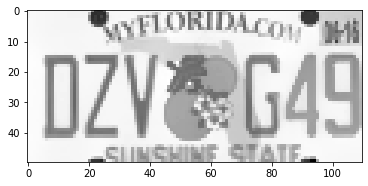

In [ ]:
img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)       # Convert to grayscale
lics = read_txt(DETECT_PATH +'labels/'+IMG_NAME+'.txt')
height, width = img.shape[:2]

for lic in lics:
    c, x, y, w, h = lic
    w = int(w*width)
    h = int(h*height)
    x1 = int(x*width - int(w/2))
    x2 = int(x*width + int(w/2))
    y1 = int(y*height - int(h/2))
    y2 = int(y*height + int(h/2))
    img_alpr = img[y1:y2,x1:x2]
    img = cv2.bilateralFilter(img_alpr, 11, 17, 17)      # Blur to reduce noise (Edges are preserved)
    # img = cv2.GaussianBlur(img_alpr, (3,3), 0)         
    plt.imshow(img, cmap='gray')
    txt = pytesseract.image_to_string(img_alpr, lang='eng')
    print(txt)
